# Deliverable 4: Final Report

## 1. Introduction

Since the beginning of the covid-19 pandemic in 2020, remote work has been on the rise globally (Brynjolfsson, E. et al., 2020). This drastic change in the way companies operate poses numerous challenges and opportunities for both employers and employees. Given the potential increases in productivity (Galanti, Teresa et al., 2021) among remote workers and the obvious decrease in operating costs for companies, it would be insightful to see if these factors point to a difference in salaries among data science professionals. Since the nature of most data science jobs allows fully remote work, it would be informative to look at salary differences between fully-remote and conventional work.

This raises an interesting question: **does salary differ between full-remote and conventional positions for full-time data science professionals?** We will provide an estimate of the mean salary for both groups(remote and conventional workers) and conduct a two-sample t-test in an attepmt to provide evidence for there being a difference between the two groups. Given the skewed nature of the salaries in our dataset, we will use the inter-quartile range to quantify the spread of the data. 


To answer our question, we discovered a dataset originally aggregated by [ai-jobs.net](https://salaries.ai-jobs.net/) through [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries). This dataset includes 607 observations with 11 factors: year, experience level, full/part-time, job titles, salary values in different currencies, employees location, remote ratio, company locations, and company sizes (more detials see 2.2).  We take the `salary_in_usd` as our response variables and take `remote_ratio` as our explanatory variable.

In [1]:
library(readr)
library(tidyr)
library(infer)
library(repr)
library(dbplyr)
library(tidyverse)
library(cowplot)
library(ggplot2)
library(digest)
library(lubridate)
library(scales)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ dplyr   1.0.9
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::ident()  masks dbplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::sql()    masks dbplyr::sql()


Attaching package: ‘lubridate’


The following object is masked from ‘package:cowplot’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## 2. Methods and Results
*Here is where you’ll include your work from the “Preliminary Results” in your proposal, along with the additional results you planned to conduct, as indicated in the “Methods: Plan” section of your proposal.* 

*Be sure to **incorporate feedback from the teaching team and your peers (as relevant)**, or **make any improvements based on your own improved understanding of the project** (now that more time has passed since the proposal).*



*Specifically, in addition to what is requested in the “Preliminary Results” section of the proposal, we are looking for the following components:*

- ***Describe in written English the methods you used** to perform your analysis from beginning to end that **narrates the code** the does the analysis.*
- *Make sure to interpret the results you obtain. It’s not enough to just state what a 90% confidence interval is, for example.*
- *Ensure your tables and/or figures are labeled with a figure/table number.*
- *Do you think one of **bootstrapping or asymptotics is more appropriate than the other**? Why or why not? Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.*

### 2.1 Data import

In [2]:
# Given the absence of an official API for R language from Kaggle, 
# we had to transfer the .csv file to Github for the required direct import process.

ds_salaries <- read_csv("https://raw.githubusercontent.com/CalicoCalliope/ds_salaries_r/main/ds_salaries.csv")

glimpse(ds_salaries)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 607
Columns: 12
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…
$ work_year          <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 202…
$ experience_level   <chr> "MI", "SE", "SE", "MI", "SE", "EN", "SE", "MI", "MI…
$ employment_type    <chr> "FT", "FT", "FT", "FT", "FT", "FT", "FT", "FT", "FT…
$ job_title          <chr> "Data Scientist", "Machine Learning Scientist", "Bi…
$ salary             <dbl> 70000, 260000, 85000, 20000, 150000, 72000, 190000,…
$ salary_currency    <chr> "EUR", "USD", "GBP", "USD", "USD", "USD", "USD", "H…
$ salary_in_usd      <dbl> 79833, 260000, 109024, 20000, 150000, 72000, 190000…
$ employee_residence <chr> "DE", "JP", "GB", "HN", "US", "US", "US", "HU", "US…
$ remote_ratio       <dbl> 0, 0, 50, 0, 50, 100, 100, 50, 100, 50, 0, 0, 0, 10…
$ company_location   <chr> "DE", "JP", "GB", "HN", "US", "US", "US", "HU", "US…
$ company_size       <chr> "L", "S", "M", "S", "L", "L", "S", "L", "L", "S", "…


### 2.2 Data cleaning and wrangling

Since our interests are on **remote work** and **salaries** for **all fulltime** data science professionals **globally**, we cleaned the data as follows:

In [21]:
df <- ds_salaries %>%

    # filter only fulltime position to create a sample for the targeted population:
    filter(employment_type=="FT") %>% 

    select(salary_in_usd,  # select converted salaries so all values are on the same scale
           remote_ratio,  # select remote ratio as the explanatory variable
           
           # include only the following potential indicators for more in-depth interests and future questions:
           company_location,  # shown in ISO 3166 country code
           experience_level)  # EN: Entry-level, MI: Mid-level, SE: Senior-level, EX: Executive-level

glimpse(df)

Rows: 588
Columns: 4
$ salary_in_usd    <dbl> 79833, 260000, 109024, 20000, 150000, 72000, 190000, …
$ remote_ratio     <dbl> 0, 0, 50, 0, 50, 100, 100, 50, 100, 50, 0, 0, 0, 100,…
$ company_location <chr> "DE", "JP", "GB", "HN", "US", "US", "US", "HU", "US",…
$ experience_level <chr> "MI", "SE", "SE", "MI", "SE", "EN", "SE", "MI", "MI",…


Although `remote_ration`  is a `double<dbl>`, it has only three values: `0`%(onsite), `50` %(hybrid),`100`% (fully remote).  

Given the purpose of the key question and the distribution of `remote_ratio` as shown below:


In [4]:
ratio_value_count <- df %>% 
    summarise(onsite = sum(remote_ratio == 0),
              hybrid = sum(remote_ratio == 50),
              fully_remote = sum(remote_ratio == 100))
              
ratio_value_count

onsite,hybrid,fully_remote
<int>,<int>,<int>
126,92,370


from here onward, we **divide the data into two groups**:
- 1. `fully_remote`
- 2. `non_fully_remote` or "conventional"

In [5]:
remote_binary <- df %>% 
    mutate(fully_remote = (remote_ratio == 100)) %>% 
    select(-remote_ratio) 

# 1. fully_remote: remote_ratio == 100, all 100%(fully-remote) 
fully_remote <- remote_binary %>% 
    filter(fully_remote == TRUE)
head(fully_remote)

# 2. non_fully_remote:  remote_ratio != 100, combine both 0%(onsite) and 50%(hybrid),
non_fully_remote <- remote_binary %>% 
    filter(fully_remote == FALSE)
head(non_fully_remote)

salary_in_usd,company_location,experience_level,fully_remote
<dbl>,<chr>,<chr>,<lgl>
72000,US,EN,TRUE
190000,US,SE,TRUE
135000,US,MI,TRUE
87000,US,MI,TRUE
85000,US,MI,TRUE
41689,JP,EN,TRUE


salary_in_usd,company_location,experience_level,fully_remote
<dbl>,<chr>,<chr>,<lgl>
79833,DE,MI,FALSE
260000,JP,SE,FALSE
109024,GB,SE,FALSE
20000,HN,MI,FALSE
150000,US,SE,FALSE
35735,HU,MI,FALSE


### 2.3 Data Exploration

#### 2.3.1 Raw data of the whole sample

With our **sample mean** (and sample median as extra reference), we plotted the raw data：

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


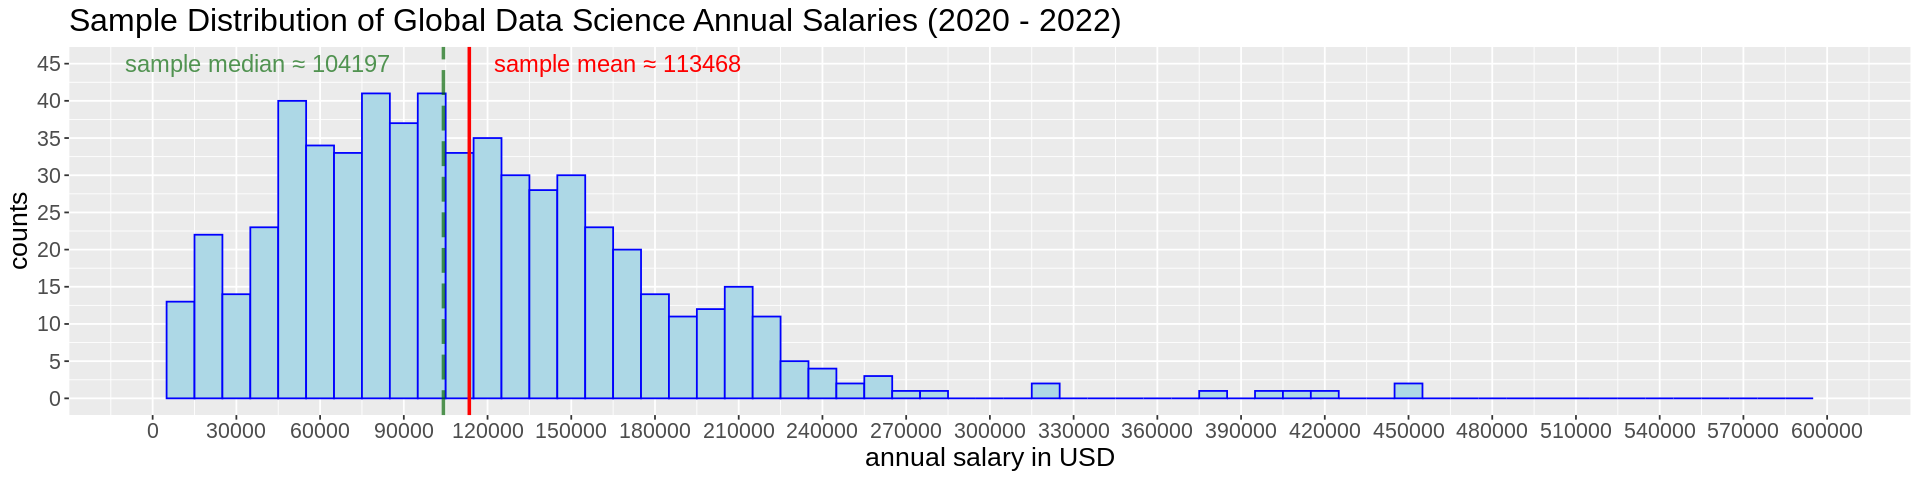

In [6]:
sample_stats <- df %>% 
    summarise(mean = mean(salary_in_usd),
             median = median (salary_in_usd))

mean_overall<- sample_stats[1] %>% pull()
median_overall <- sample_stats[2] %>% pull()

options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)

all_salary_plot  <- df %>% 
    ggplot(aes(x = salary_in_usd)) + 
    geom_histogram(binwidth = 10000, colour = 'blue', fill = 'light blue') +
    labs(title = "Sample Distribution of Global Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +
    
    # add in sample mean and sample meadian as reference:
    geom_vline(xintercept = mean_overall, colour = 'red', size = 1, linetype = "solid") +
        annotate("text", x = mean_overall, y = 45,label = "sample mean ≈ 113468", color = "red", size=5, hjust = -0.1) +
    geom_vline(xintercept = median_overall, colour = 'dark green', alpha = 0.66, size = 1, linetype = "longdash") +
        annotate("text", x = median_overall, y = 45, label = "sample median ≈ 104197", color = "dark green", alpha = 0.66, size=5, hjust = 1.2)+ 

    # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 45), breaks = seq(0, 45, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

all_salary_plot 

In [7]:
cat(" The over all sample mean is", mean_overall, "USD,","\n","and the over all sample median is", median_overall, "USD.")

 The over all sample mean is 113468 USD, 
 and the over all sample median is 104196 USD.

- The sample distriution is right-skewed. 
- Two of the largest outliers are hidden by `geom_bar`(see warning message), but their values are included in the adjuested range of the x-axis using `scale_x_continuous`. The actually two rows are not removed or affected in the data frame.

#### 2.3.2 Point Estimates and Confidence Intervals for both Groups

Since our interests are the differences, we look into both groups for their group mean salaries:

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


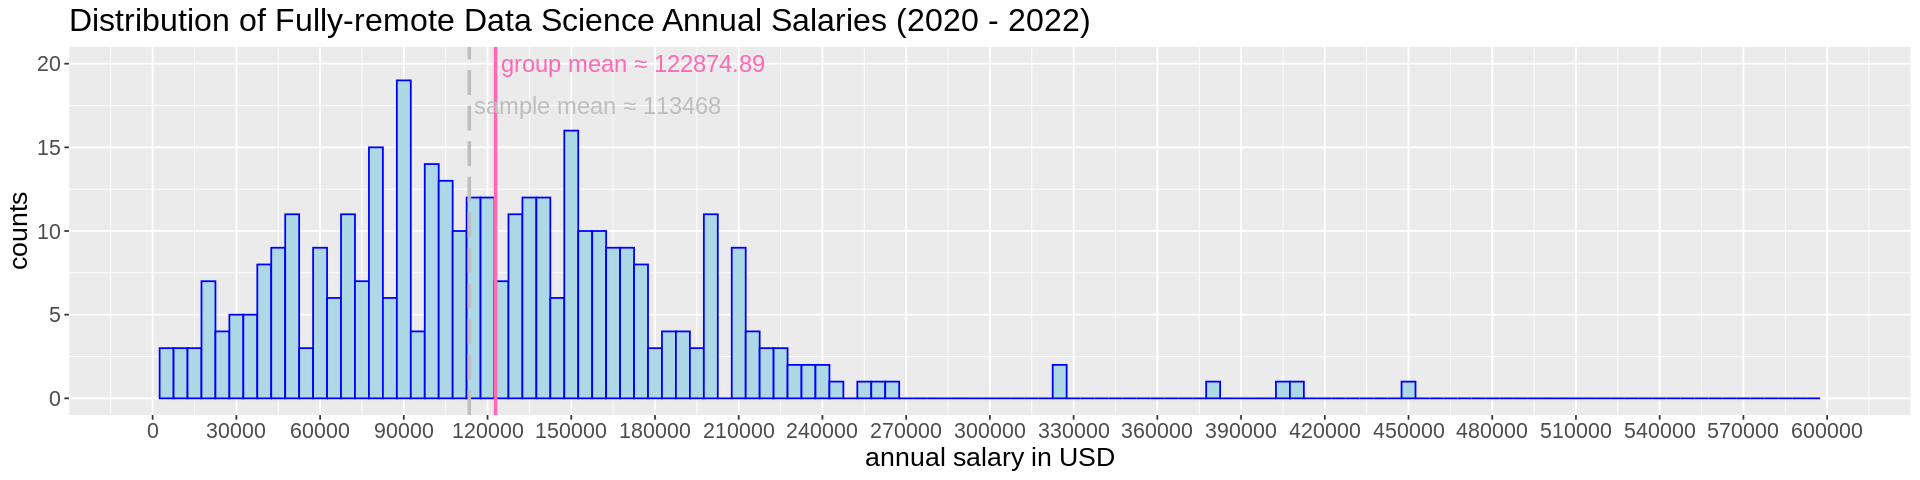

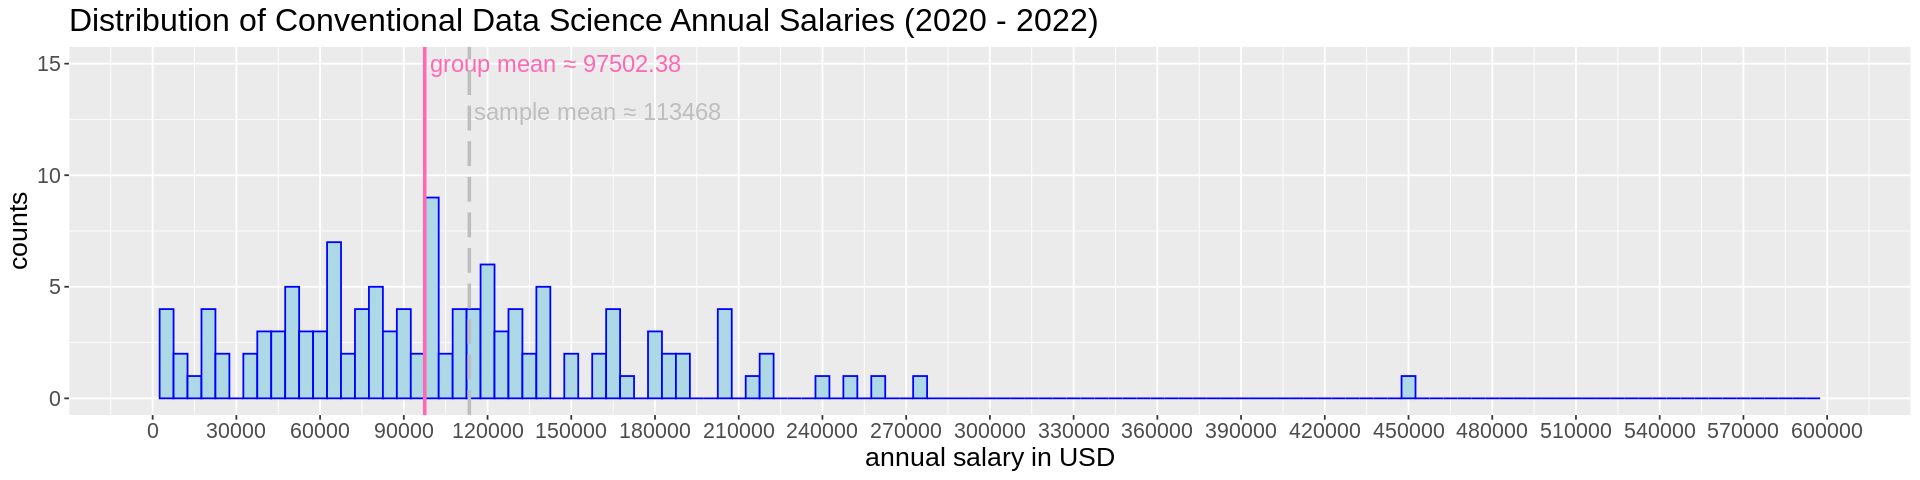

In [8]:
options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)

# 1. Fully_remote: 
fully_remote_mean <- fully_remote %>% 
    summarise(mean = mean(salary_in_usd)) %>% 
    pull()

remote_plot <- df %>%
    filter(remote_ratio == 100) %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Fully-remote Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    # add in coloured vertical lines with labels for group mean and group meadian as reference:
    geom_vline(xintercept = fully_remote_mean, colour = 'hot pink', size = 1, linetype = "solid") +
        annotate("text", x = fully_remote_mean, y = 20, label = "group mean ≈ 122874.89", color = "hot pink", size = 5, hjust = -0.02) +
    # geom_vline(xintercept = 115717, colour = '#00827f', alpha = 0.36, size = 1, linetype = "longdash") +
    #     annotate("text", x = 115717, y = 20, label = "median = 115717", color = '#00827f', alpha = 0.36, size=5, hjust = 1.1) +

    # add grey vertical lines for sample mean and sample meadian from sections above:
    geom_vline(xintercept = mean_overall, colour = 'grey', size = 1, linetype = "longdash") +
        annotate("text", x = mean_overall, y = 19, label = "sample mean ≈ 113468", color = "grey", size = 5, hjust = -0.02, vjust = 2) +


   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

remote_plot


# 2. Non_fully_remote:  
non_fully_remote_mean <- non_fully_remote %>% 
    summarise(mean = mean(salary_in_usd)) %>% 
    pull()

conventional_plot <- df %>%
    filter(remote_ratio == 0 & 50) %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Conventional Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    # add in coloured vertical lines with labels for group mean and group meadian as reference:
    geom_vline(xintercept = non_fully_remote_mean, colour = 'hot pink', size = 1, linetype = "solid") +
        annotate("text", x = non_fully_remote_mean, y = 15, label = "group mean ≈ 97502.38", color = "hot pink", size = 5, hjust = -0.02) +
#     geom_vline(xintercept = 85000, colour = '#00827f', alpha = 0.36, size = 1, linetype = "longdash") +
#         annotate("text", x = 85000, y = 15, label = "median = 115717", color = '#00827f', alpha = 0.36, size=5, hjust = 1.1) +
    
    # add grey vertical lines for sample mean and sample meadian from sections above:
    geom_vline(xintercept = mean_overall, colour = 'grey', size = 1, linetype = "longdash") +
        annotate("text", x = mean_overall, y = 14, label = "sample mean ≈ 113468", color = "grey", size = 5, hjust = -0.02, vjust = 2) +
    # geom_vline(xintercept = 104196, colour = 'grey', size = 1, linetype = "longdash") +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 15), breaks = seq(0, 15, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

conventional_plot


In [9]:
cat(" The sample mean of the fully-remote group is", fully_remote_mean, "USD,","\n","and the sample mean of the non-fully-remote group is", round(non_fully_remote_mean, 5), "USD.")

 The sample mean of the fully-remote group is 122875 USD, 
 and the sample mean of the non-fully-remote group is 97502 USD.

The mean of the *fully-remote* group is higher than the overall sample mean, whereas it is lower for the conventional group. 

To depict the **uncertainty** in these point estimates, we construct **95% confidence intervals** for both group's sample means using percentile method with bootstraping:

lower_ci,upper_ci
<dbl>,<dbl>
115910,130404


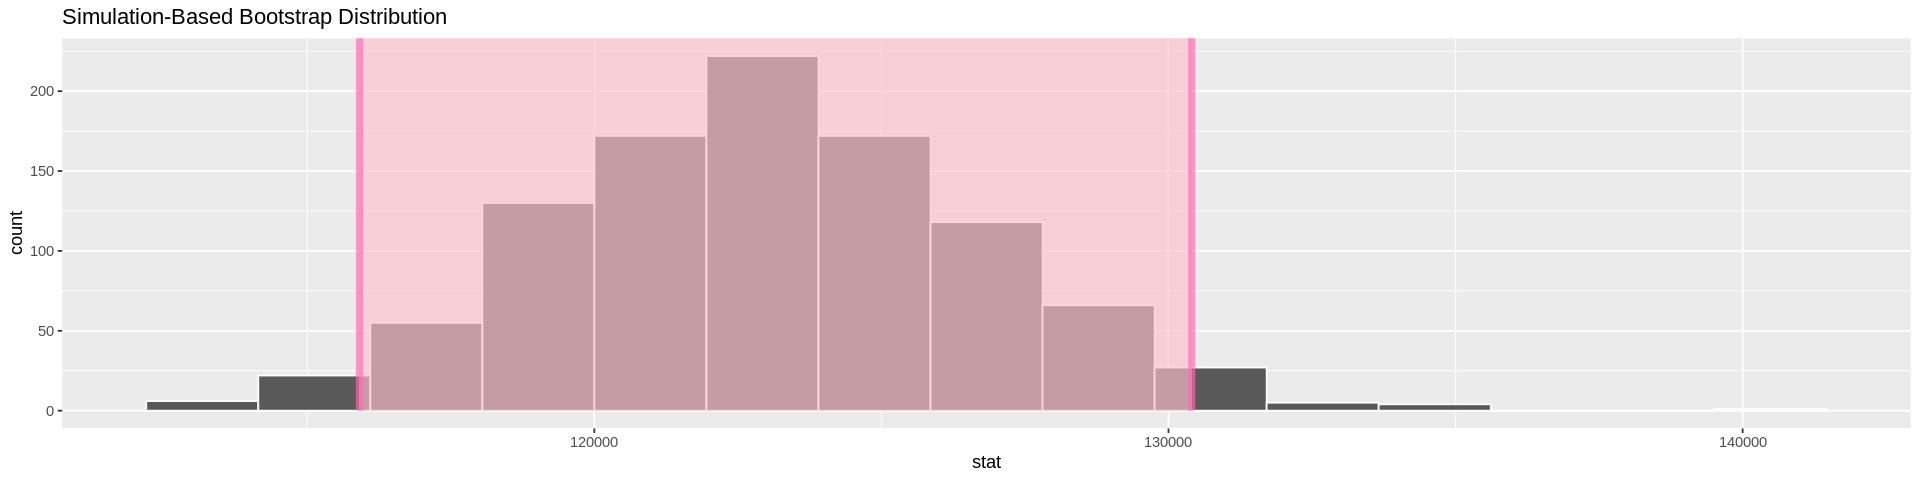

In [10]:
set.seed(6666)

# 1. Fully-remote:
fully_remote_resample  <-  fully_remote %>%
    specify(response = salary_in_usd) %>%
    generate(reps = 1000, type = "bootstrap") %>%                        
    calculate(stat = "mean") 
# head(fully_remote_resample)

fully_remote_percentile_ci <- fully_remote_resample %>% 
  get_confidence_interval(level = 0.95, type = "percentile") 
fully_remote_percentile_ci

fully_remote_ci_plot <- 
    visualize(fully_remote_resample) + 
    shade_ci(endpoints = fully_remote_percentile_ci, color = "hotpink", fill = "pink", alpha = 0.66)
fully_remote_ci_plot

lower_ci,upper_ci
<dbl>,<dbl>
89522,105904


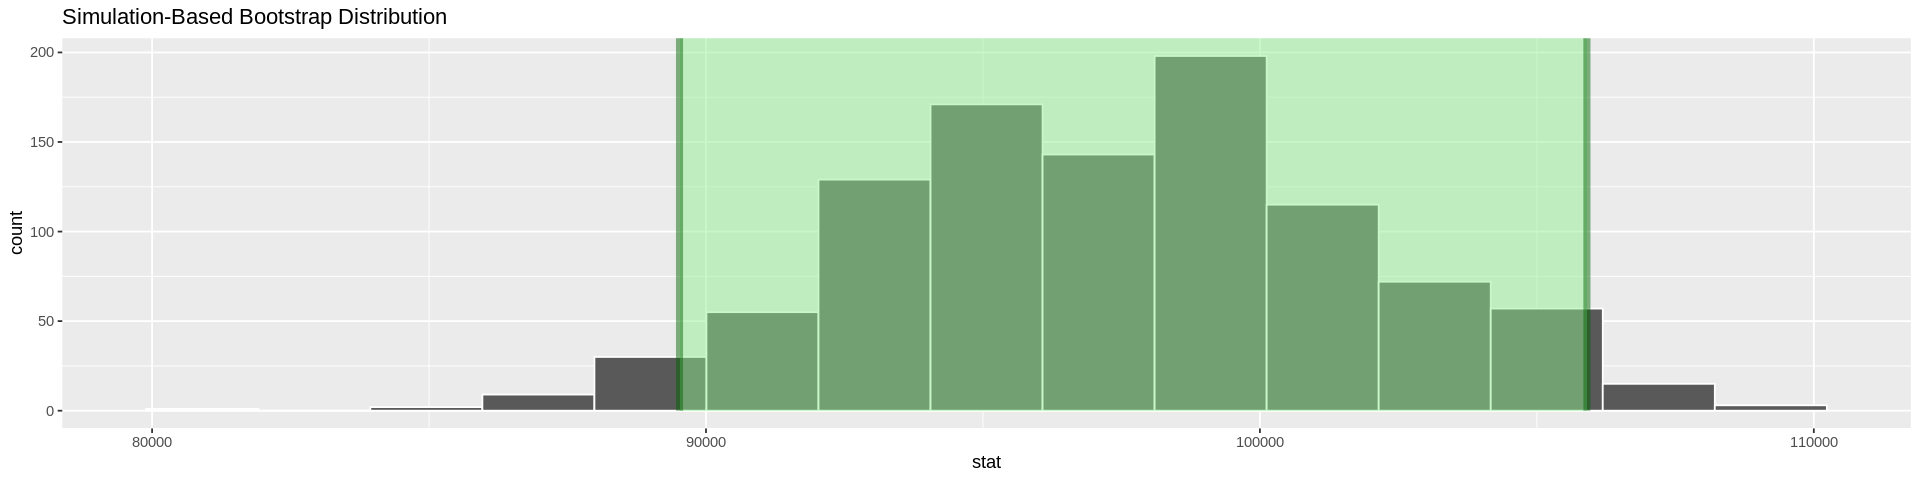

In [11]:
# 2. Non-fully-remote:
non_fully_remote_resample  <- non_fully_remote %>%
    specify(response = salary_in_usd) %>%
    generate(reps = 1000, type = "bootstrap") %>%                        
    calculate(stat = "mean")    
# head(non_fully_remote_resample)

non_fully_remote_percentile_ci <- non_fully_remote_resample %>% 
  get_confidence_interval(level = 0.95, type = "percentile") 
non_fully_remote_percentile_ci

non_fully_remote_ci_plot <- 
    visualize(non_fully_remote_resample) + 
    shade_ci(endpoints = non_fully_remote_percentile_ci, color = "dark green", fill = "light green", alpha = 0.48)
non_fully_remote_ci_plot

Interpretation :

...95% confident that ... 

...95% confident that ... 


To improve:
- covert to same scale with infer package
- title and labels with infer package

 

However, confidence intervals **do not quantify variation**. There could be bias in the sampling or an inability to obtain data from a certain subset of the population. We need look further into the data for a better understanding.

#### 2.3.3 Variation and Scale Parameter for both Groups

Considering there are various potential indicators for the means, we need to know more about the **variation**. Given the heavy right tail, we calculated **inter-quartile range** instead of standard deviation:

In [12]:
options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)


# 1. fully remote group:
lower_quantile_fully_remote <- 
    fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.25)

upper_quantile_fully_remote <- 
    fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.75)

median_fully_remote <- fully_remote %>% 
    summarise(median = median(salary_in_usd)) %>% 
    pull()

plot_IQR_fully_remote <- fully_remote %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "IQR of Annual Salaries for Fully Remote Data Science(2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    geom_vline(xintercept = lower_quantile_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = lower_quantile_fully_remote, y = 18, label = "Q1: 76944", color = 'aquamarine3', size = 5, hjust = 1.1) +
    geom_vline(xintercept = upper_quantile_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = upper_quantile_fully_remote, y = 18, label = "Q3: 160000", color = 'aquamarine3', size = 5, hjust = -0.1) +
    annotate("rect", xmin = lower_quantile_fully_remote, xmax = upper_quantile_fully_remote, ymin = 0, ymax = Inf,
             fill = "aquamarine",
             alpha = 0.3) +
    geom_vline(xintercept = median_fully_remote, colour = 'aquamarine4', size = 1, linetype = "solid") +
        annotate("text", x = median_fully_remote, y = 20, label = "median: 115717", color = 'aquamarine4', size=5, hjust = -0.1) +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 


# 2. non fully remote group:
lower_quantile_non_fully_remote <- 
    non_fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.25)

upper_quantile_non_fully_remote <- 
    non_fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.75)

median_non_fully_remote <- non_fully_remote %>% 
    summarise(median = median(salary_in_usd)) %>% 
    pull()


plot_IQR_non_fully_remote <- non_fully_remote %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "IQR of Annual Salaries for Conventional Data Science (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    # add in coloured vertical lines with labels for group mean and group meadian as reference:
    geom_vline(xintercept = lower_quantile_non_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = lower_quantile_non_fully_remote, y = 13, label = " Q1: 55314", color = 'aquamarine3', size = 5, hjust = 1.1) +
    geom_vline(xintercept = upper_quantile_non_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = upper_quantile_non_fully_remote, y = 13, label = " Q3: 124833", color = 'aquamarine3', size = 5, hjust = -0.1) +
    annotate("rect", xmin = lower_quantile_non_fully_remote, xmax = upper_quantile_non_fully_remote, ymin = 0, ymax = Inf,
             fill = "aquamarine",
             alpha = 0.3) +
    geom_vline(xintercept = median_non_fully_remote, colour = 'aquamarine4', size = 1, linetype = "solid") +
        annotate("text", x = median_non_fully_remote, y = 15, label = "median: 85000", color = 'aquamarine4', size=5, hjust = -0.1) +
    
   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 15), breaks = seq(0, 15, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 


Fully-remote Group: 
 Q1:  76944 
 median:  115717 
 Q3:  160000 

 Non-fully-remote Group: 
 Q1:  55314 
 median:  85000 
 Q3:  124833

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


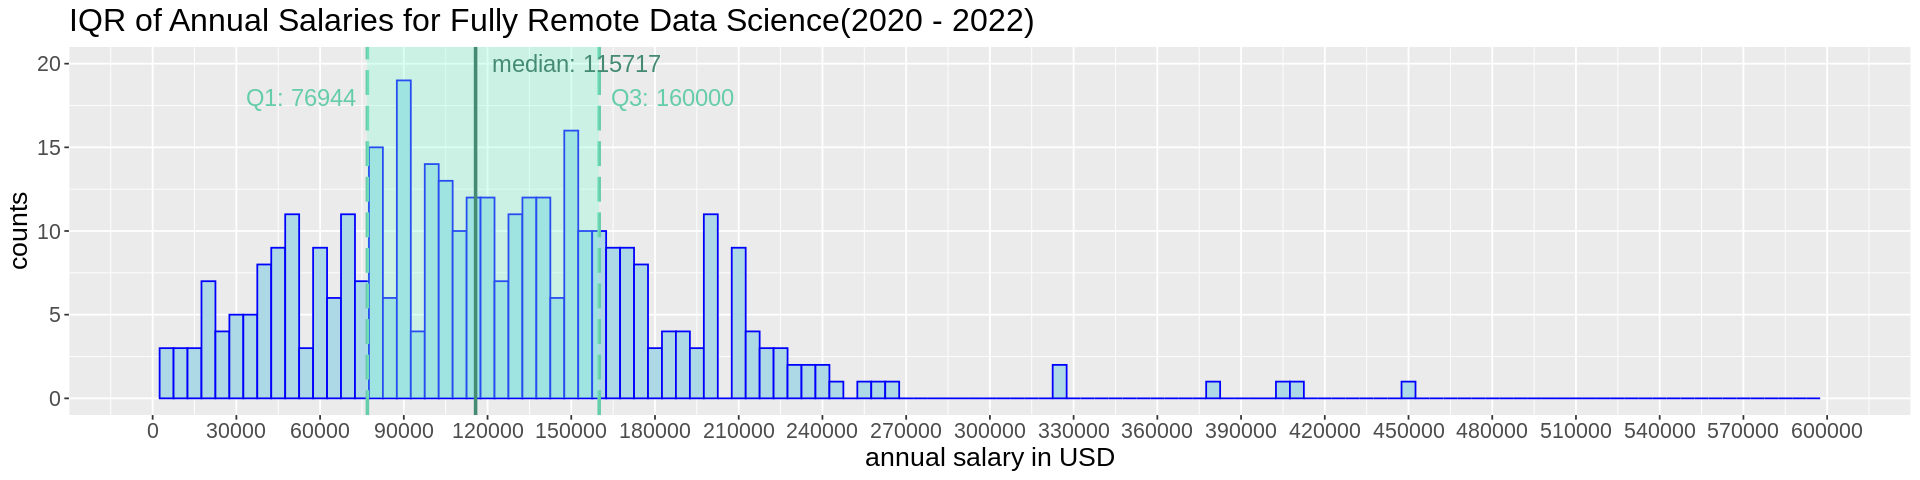

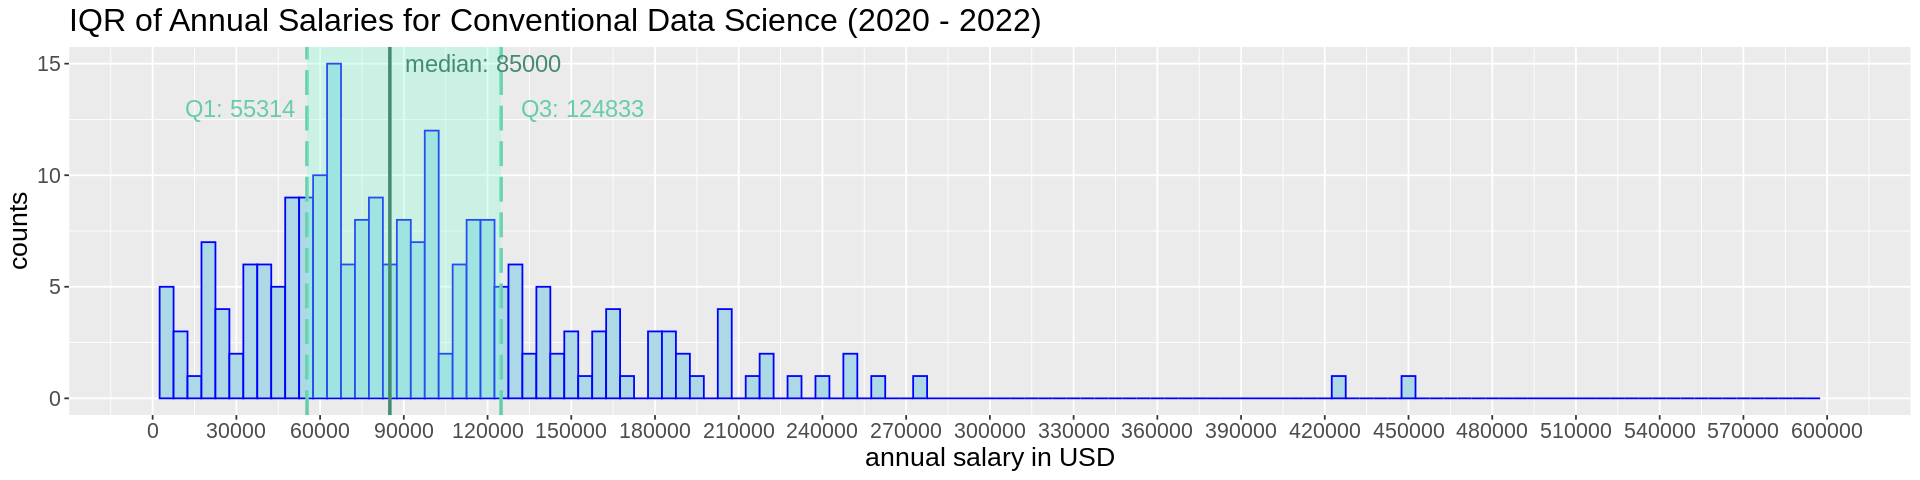

In [13]:
cat("Fully-remote Group:", 
    "\n", "Q1: ", lower_quantile_fully_remote, 
    "\n", "median: ", median_fully_remote,
    "\n", "Q3: ", upper_quantile_fully_remote,
    "\n")  

cat("\n",
    "Non-fully-remote Group:", 
    "\n", "Q1: ", lower_quantile_non_fully_remote, 
    "\n", "median: ", median_non_fully_remote,
    "\n", "Q3: ", upper_quantile_non_fully_remote)

plot_IQR_fully_remote
plot_IQR_non_fully_remote

Fully-remote group has a larger (also higher) inter-quartile range, which indicates a relatively larger variation.

#### 2.3.3 Fully-remote v.s. Non-fully-remote Groups

With calculated IQR, in order to investigate the actual salary difference, we start by comparing the two groups side by side using **boxplots**:

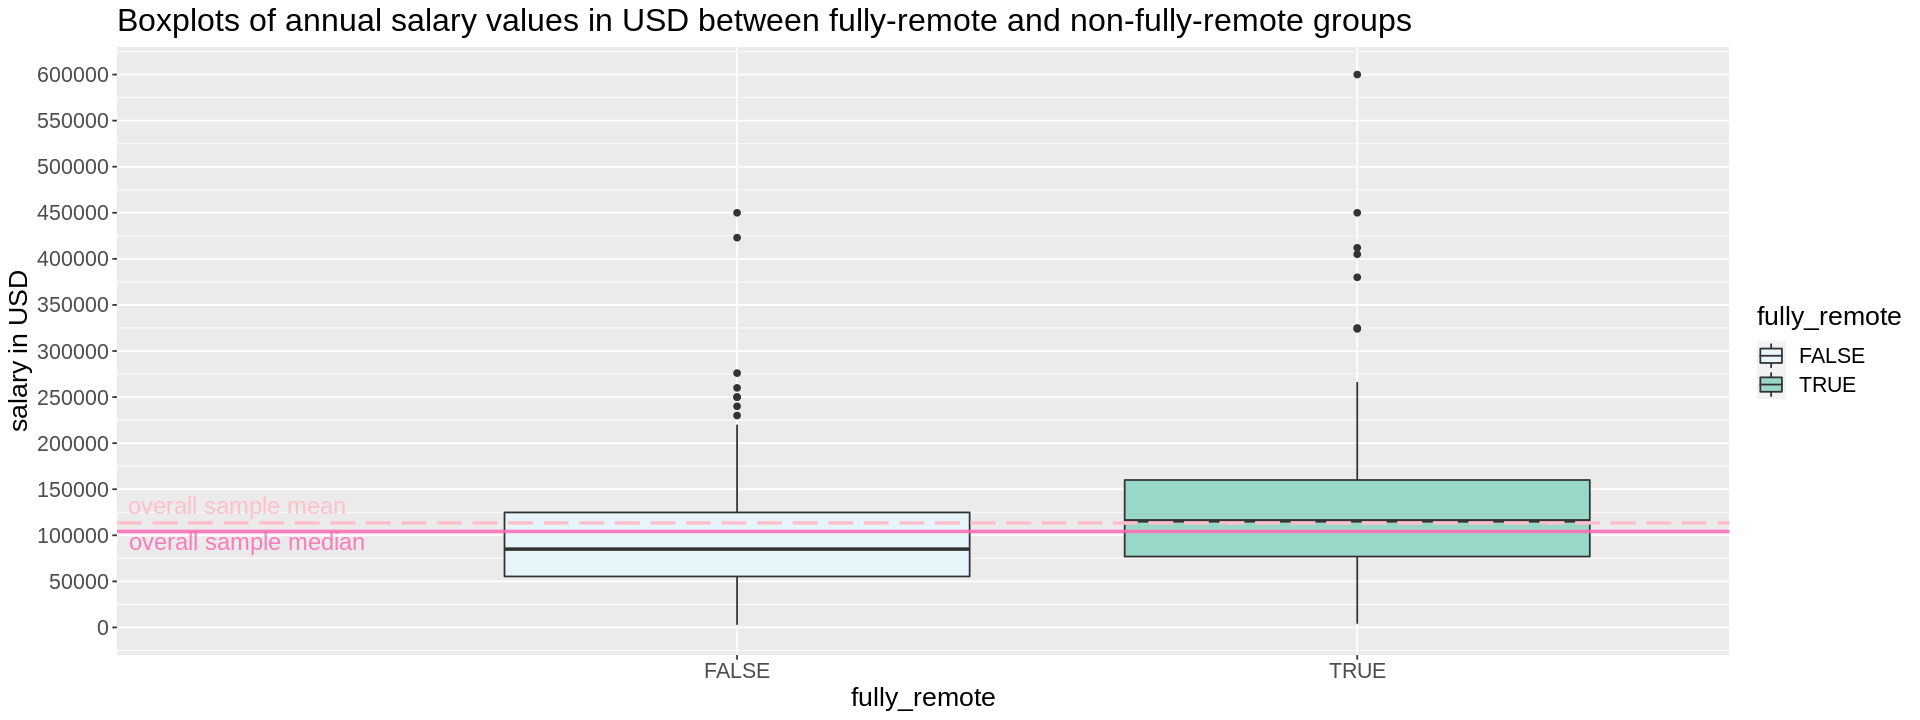

In [14]:
options(repr.plot.width = 16, repr.plot.height = 6)
options("scipen"=10, "digits"=4)

boxplots_all <- remote_binary %>%  
    ggplot(aes(x = fully_remote, y = salary_in_usd, fill = fully_remote)) + 
    scale_fill_brewer(palette = "BuGn") +
    geom_boxplot() + 
    ylab("salary in USD") +
    ggtitle("Boxplots of annual salary values in USD between fully-remote and non-fully-remote groups") +
    theme(text = element_text(size=16)) +
    geom_hline(yintercept = mean_overall, color = "pink", size = 1, linetype = "longdash") +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "pink", size=5, hjust = -0.05, vjust = -0.5) +
    geom_hline(yintercept = median_overall, color = "hotpink", size = 1, linetype = "solid", alpha = 0.86) +
        annotate("text", x = 0, y = median_overall,label = "overall sample median", color = "hotpink", size=5, hjust = -0.05, vjust = 1.1, alpha = 0.86)+

    # refine the limits and breaks of the y scales:
    scale_y_continuous(limits = c(0, 600000), breaks = seq(0, 600000, 50000)) 

boxplots_all

In this boxplot, we see there is indeed a difference. The fully-remote group shows a higher salary.

### 2.4 Data Analysis


To anwer our question about the salary difference, we conduct **hypothesis testings** using both **bootstrapping** and **asymptotics** methods:

Given the boxplot above, we define our hypothesis at $\alpha = 0.10$:
- $H_0$: $\mu_r$ - $\mu_n$ = 0
- $H_a$: $\mu_r$ - $\mu_n$ > 0

where $\mu_r$ is the true salary mean for fully-remote group (`fully_remote == TRUE`), and $\mu_n$ is the true salary mean for the conventional group(`fully_remote == FALSE`).

#### 2.4.1 Simulation-based Hypothesis Testing (Bootstrapping)

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


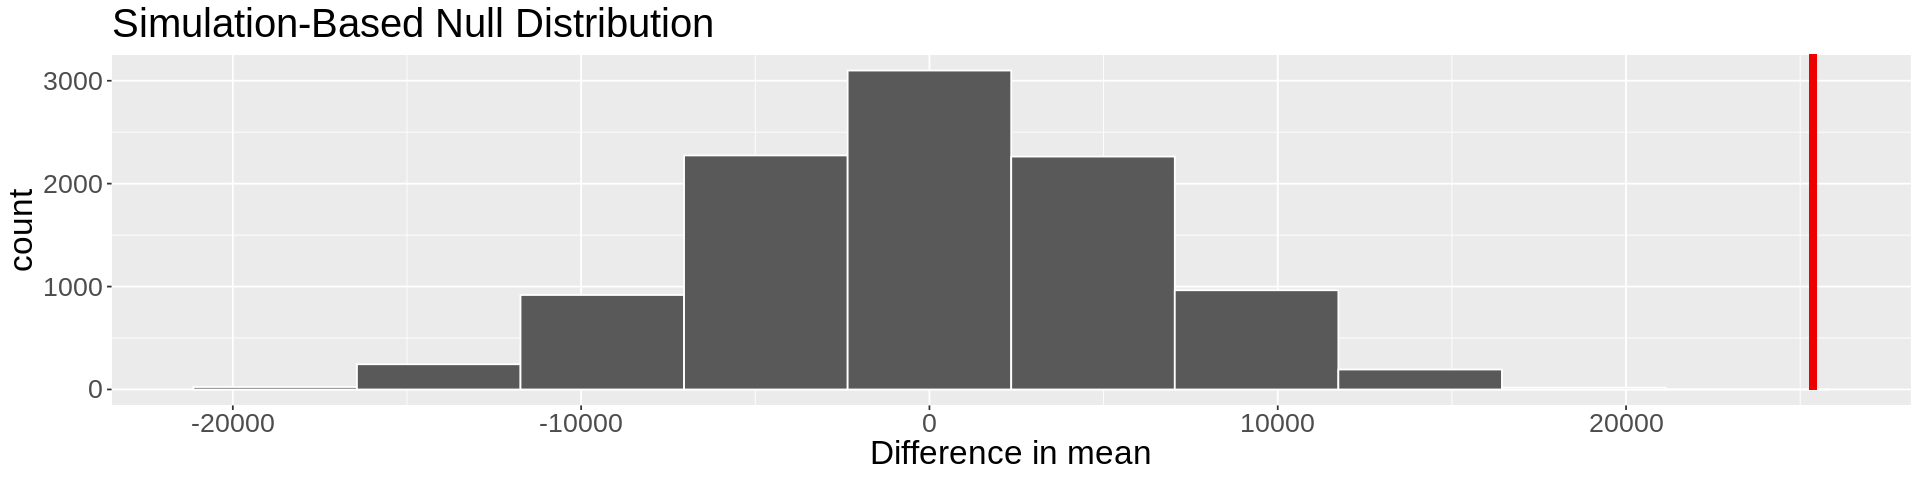

In [15]:
# calculate observed test statistic 
obs_diff_in_means <- 
    remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))

# build the null distribution
null_dist <-remote_binary  %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
# head(null_dist)

# visualization 
options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen" = 10, "digits" = 4)

diff_in_medians_plot <-
    visualize(null_dist, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
    xlab("Difference in mean") +
    theme(text = element_text(size = 20))
diff_in_medians_plot

# get p value
p_value <- null_dist %>% 
    get_p_value(obs_stat = obs_diff_in_means, direction = "right")
p_value


- Interpretation:  

...



The $p ≈ 0$ p-value indicates ....

#### 2.4.2 Theory-based Hypothesis Testing (Asymptotics)

In [23]:
# Check sample size for both groups:

size_fully_remote <- fully_remote %>%
    summarise(count = n()) %>%
    pull()

size_non_fully_remote <- non_fully_remote %>%
    summarise(count = n()) %>%
    pull()

cat(" Fully-remote: n =", size_fully_remote, "\n", "Non-fully-remote: n =", size_non_fully_remote, "\n") 

 Fully-remote: n = 370 
 Non-fully-remote: n = 218 


Given the sample size of both groups are large enough for the t-distribution to converge to the normal distribution, the difference of using the z-distribution instead of t-distribution diminishes. We, therefore, choose to conduct a t-test using `broom::tidy()` for tidier and more organized results.

In [17]:
t_test_results <- tidy(t.test(x = remote_binary %>% filter(fully_remote == "TRUE") %>% pull(salary_in_usd), 
                              y = remote_binary %>% filter(fully_remote == "FALSE") %>% pull(salary_in_usd),
                              alternative = "greater"))

t_test_results

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
25373,122875,97502,4.452,0.000005279,490.7,15980,Inf,Welch Two Sample t-test,greater


This very small p-value ($p= 0.000005279$) indicates that it is quite unlikely to get the observed test statistic if $H_0$ were true, which _suggests_ that $H_0$ is more likely to be false. Therefore, $H_0$ should also be rejected at $\alpha = 0.10$. 

Although both bootstrapping and asymptotics methods gave us the similar results to reject $H_0$, the **asymptotics** method is **more appropriate** for this data set. This is because:
1. Compared to asymptotics, the precision of bootstrapping much more depends on the original observations. In this sample, although the sample size is large enough, the distribution is not very well balance, and it contains large outliers. Either of these could affect the resampling results and therefore provide a less indicative p-value.
2. The p-value of the bootstrapping result is only an approximation based on the number of `reps` chosen in the `generate()` step. In this case, when the actual p-value is very small, we can only interpret as $p ≈ 0$ with bootstrapping, but asymptotics results tells us more precisely about how small p-value could be, $p ≈ 0.000005279$.




## 3. Discussion

### 3.1 Findings and implications

The results from both bootstraping and asymptotics are consistent, which provided us enough evidence to reject $H_0$ in favour of $H_a$. That suggests **the fully-remote group is more prone to higher salaries than the conventional group**.

However, does this result really applicable to all data science professionals **globally**? Is there truly a universally shared trend for **all regions**? 

Meanwhile, not only we noticed the data might not be well-balanced, we were also aware that the salary values we used were all different currencies converted to USD without standardization.  With all these known complications in our sample, just knowing this general difference given by small p-values is not fully trustworthy or informative enough for our true inquisitivity about the salary difference.

#### 3.1.1  Reliability check for US v.s. Others

We dig deeper to sanity check potential regional differences. 

In addition to the USD convertion, given the nature of survey-based data collection, we suspect US data may play a bigger role than we expected in this sample. We, therefore, single out US as one group and combine the rest of the countires for comparison. 

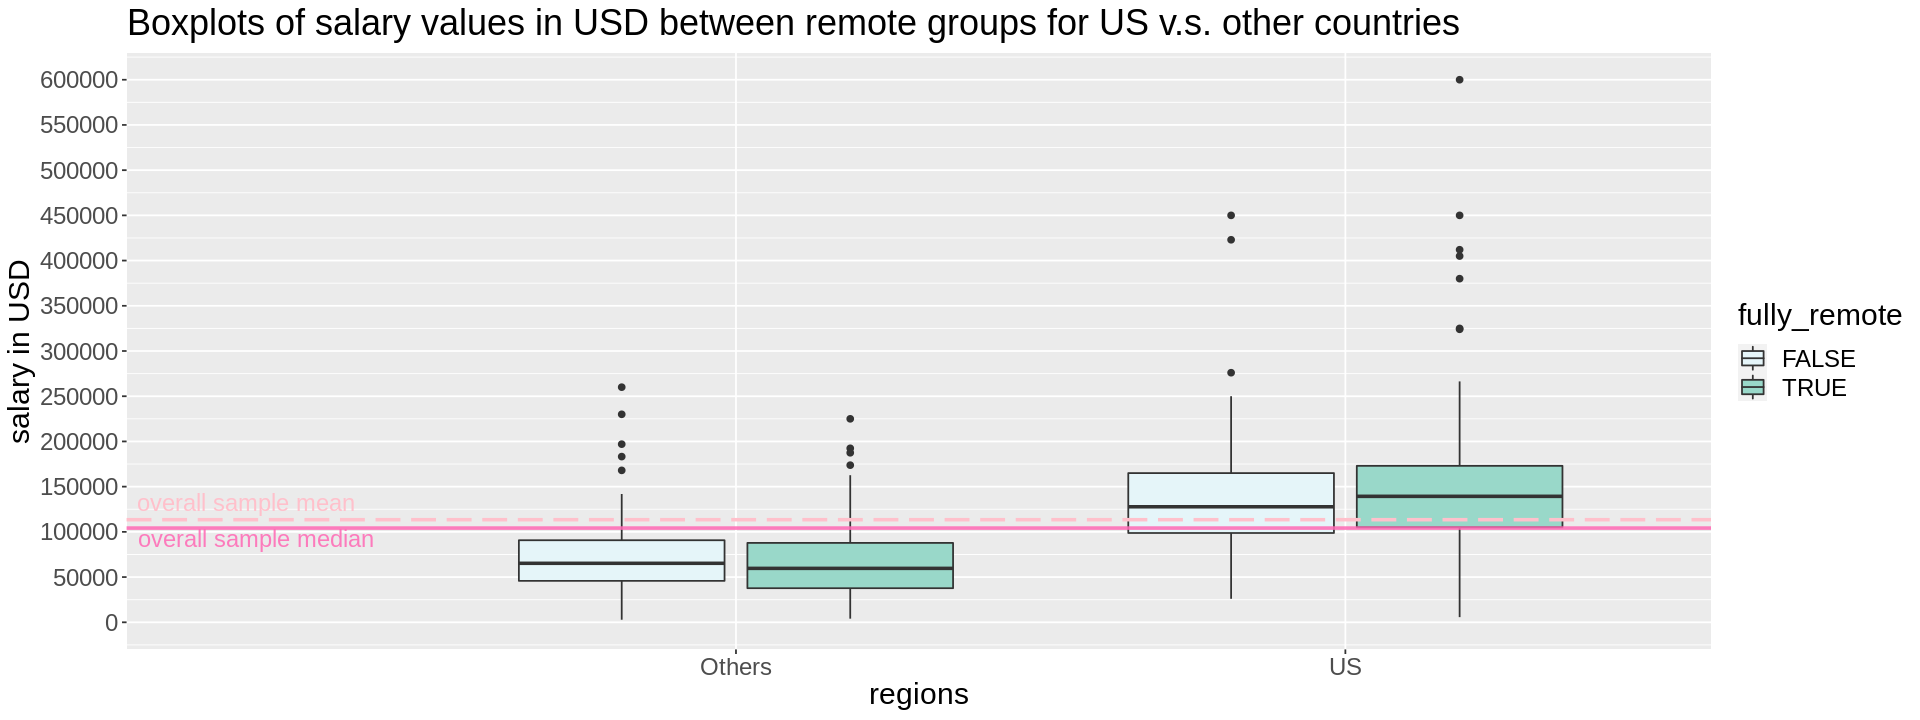

In [27]:
# Duplicate original cleaned dataframe to re-assign region groups
remote_binary_region_groups <- remote_binary

# Re-categorize countries into US and Others
remote_binary_region_groups["company_location"][remote_binary_region_groups["company_location"] != "US"] <- "Others"
# head(remote_binary_region_groups)

# Visualization in boxplots
options(repr.plot.width = 16, repr.plot.height = 6)
options("scipen"=10, "digits"=4)

boxplots_regions_remote <- remote_binary_region_groups %>%  
    ggplot(aes(x = company_location, y = salary_in_usd, fill = fully_remote)) + 
    scale_fill_brewer(palette = "BuGn") +
    geom_boxplot() + 
    xlab("regions") +
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD between remote groups for US v.s. other countries") +
    theme(text = element_text(size=18)) +
    
    # add overall mean and median for reference
    geom_hline(yintercept = mean_overall, color = "pink", size = 1, linetype = "longdash") +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "pink", size=5, hjust = -0.05, vjust = -0.5) +
    geom_hline(yintercept = median_overall, color = "hotpink", size = 1, linetype = "solid", alpha = 0.86) +
        annotate("text", x = 0, y = median_overall,label = "overall sample median", color = "hotpink", size=5, hjust = -0.05, vjust = 1.1, alpha = 0.86) +
    
    # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 600000), breaks = seq(0, 600000, 50000)) 

boxplots_regions_remote

This boxplot brings our attention to the opposite trends outside of US and how the outliers scatter in each group. We dive back in the original sample to see how the data is clustered.

total_count
<int>
588


`summarise()` has grouped output by 'company_location'. You can override using
the `.groups` argument.


company_location,fully_remote,count,proportion
<chr>,<lgl>,<int>,<dbl>
Others,FALSE,130,0.2211
Others,TRUE,112,0.1905
US,FALSE,88,0.1497
US,TRUE,258,0.4388


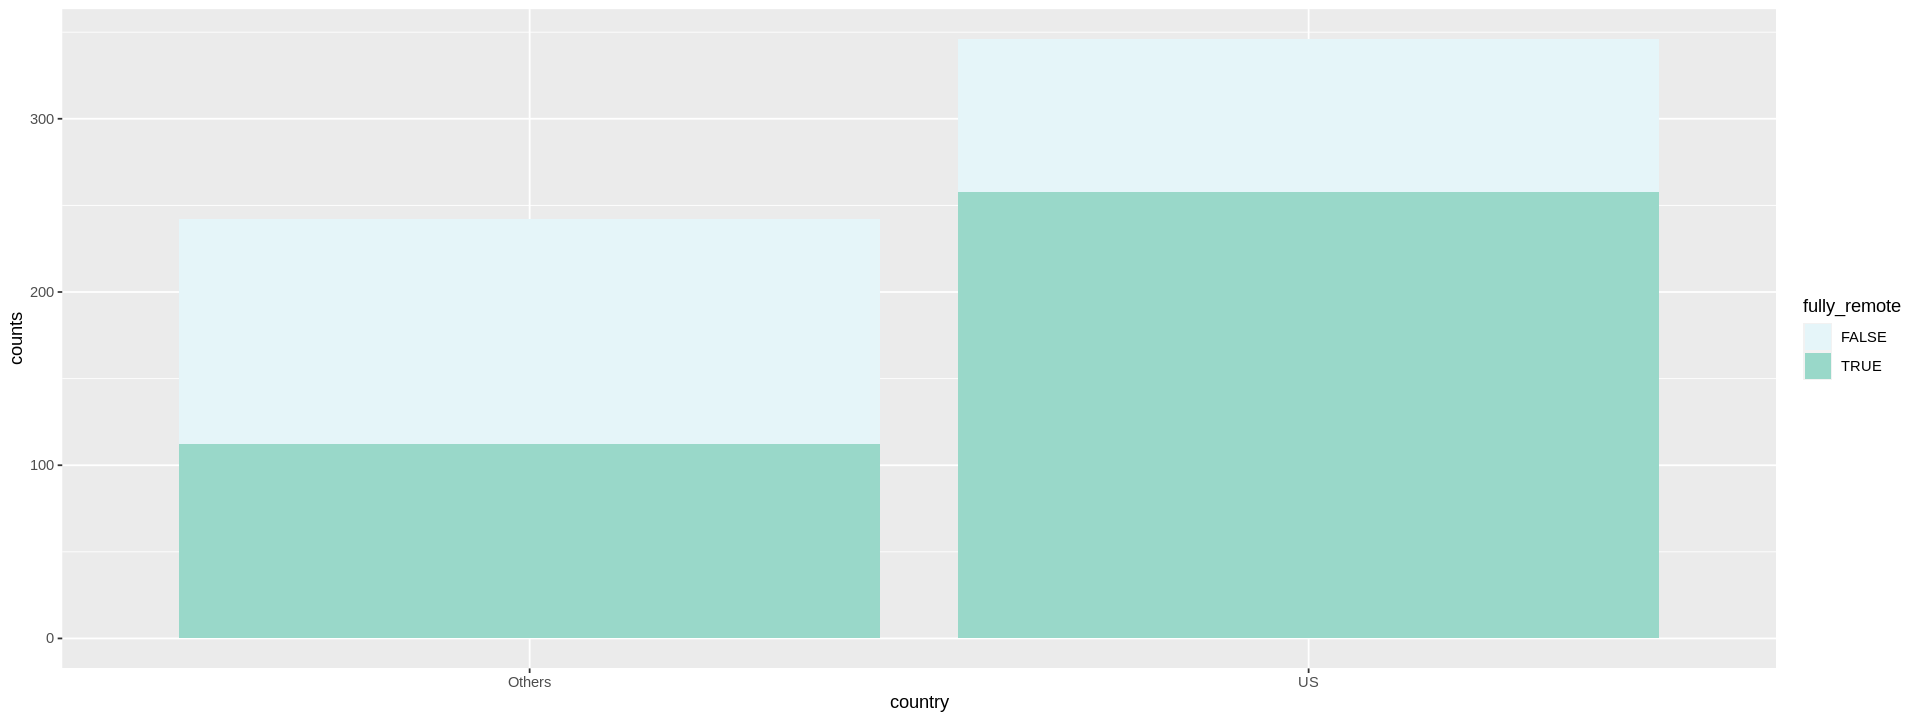

In [56]:
total_count <- remote_binary_region_groups %>% summarise(total_count = length(salary_in_usd))
total_count

options(repr.plot.width = 16, repr.plot.height = 6)
options("scipen"=10, "digits"=4)

tally_four_groups <- remote_binary_region_groups %>%
    group_by(company_location, fully_remote) %>%
    summarise(count = length(company_location),
              proportion = count / 588)
tally_four_groups

stack_four_groups_count <- tally_four_groups %>%
    ggplot(aes(x = company_location, y = count, fill = fully_remote)) + 
    scale_fill_brewer(palette = "BuGn") +
    geom_bar(position='stack', stat='identity') +
    xlab("country") +
    ylab("counts")
 
stack_four_groups_count

We observe, as one single country, US not only occupies the majority of data (59%), US fully-remote alone (biggest rectangle) has a larger proportion (44%) than both remote groups combined in all other counties (41%).  US also has many more fully-remote data collected than non-fully-remote (74% fully-remote) than other countries (46% fully-remote).  This could be some unique remote work trend in US, but without further proof, it may just due to the nature of survey-based data collection. 

This unbalance in our sample may have some greater impact in our previous inference analysis than we expected. Those extremely small p-values could be just weighted down by this unbalance of US data.

#### 3.1.2  Zoom into the unbalance and re-test
Would the result still be the same if we just look into US? 

We re-run the hypothese testing at $\alpha = 0.10$, but only on US data:
- $H_0$: $\mu_r$ - $\mu_n$ = 0
- $H_a$: $\mu_r$ - $\mu_n$ > 0

p-value for US region with bootstrapping: 0.1297 
p-value for US region with t-test: 0.1389 


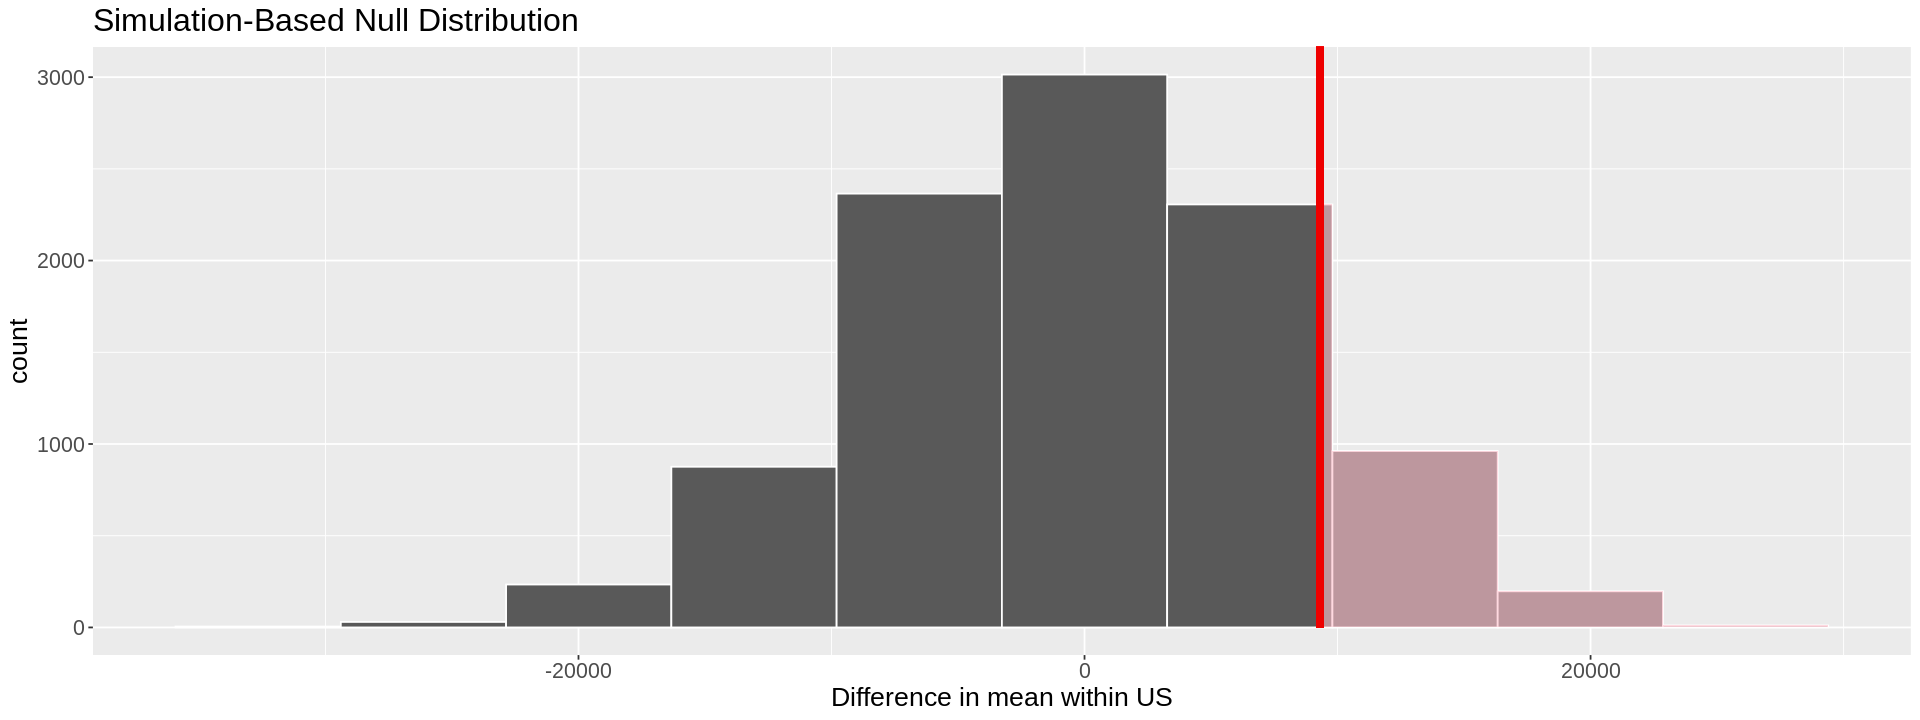

In [20]:
set.seed(6666)

# Seperate US from the data:
us_remote_binary <- remote_binary %>% 
    filter(company_location == "US")


# Same bootstraping:
# calculate observed test statistic 
us_obs_diff_in_means <- 
    us_remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))

# build the null distribution
us_null_dist <- us_remote_binary %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))

# visualization 
us_diff_in_means_plot <-
    visualize(us_null_dist, bins = 10) + 
    shade_p_value(obs_stat = us_obs_diff_in_means, direction = "right") +
    xlab("Difference in mean within US") +
    theme(text = element_text(size = 16))
us_diff_in_means_plot

# get p value
us_p_value <- us_null_dist %>% 
    get_p_value(obs_stat = us_obs_diff_in_means, direction = "right") %>%
    pull()
cat("p-value for US region with bootstrapping:", us_p_value, "\n")


# Same t-test:
us_t_test_results <- tidy(t.test(x = us_remote_binary %>% filter(fully_remote == "TRUE") %>% pull(salary_in_usd), 
                              y = us_remote_binary %>% filter(fully_remote == "FALSE") %>% pull(salary_in_usd),
                              alternative = "greater"))
cat("p-value for US region with t-test:", pull(us_t_test_results[5]), "\n")


This time, both bootstrapping and asymptotics results consistently indicate we fail to reject $H_0$ at $\alpha = 0.10$ in US.

### 3.2 Expectations and actual findings

Based on what we found in the literature and what we observed in all the preliminary results, we expected to see the salaries would be higher for fully-remote positions. We did find what we expected when we conducted the analysis on the given sample directly and credulously. 

However, once we investigated further and observed the unbalance in data, we discovered how our p-values could be affected by the original sample and therefore not as indicative. While $H_0$ might still be false globally for our population, with this specific sample we actually don’t have strong enough evidence to say so. In other words, there is an absence of enough proof. However, the absence of proof is not proof of absence. 

At this point, the only conclusion we could have would be we do not have enough evidence to reject the null hypothesis that there is no difference in salaries between fully-remote and non-fully remote groups within US ($H_0$: $\mu_r$ - $\mu_n$ = 0) with the risk of Type II error.

### 3.3 Future questions and research

#### 3.3.1 Strategies for unbalanced data


The most primary question for the next step would be how to reduce the impact from the unbalance of US data; for instance, by balancing out the sample size of each group, optimizing the data colletion, etc.

#### 3.3.2 Other indicators
There are many more potential indicators for salaries in this dataset could affect the difference. It could be as intriguing to investigate their influnces. For instance, we looked into experience level, and there are many interesting partterns to explore just from the boxplots.

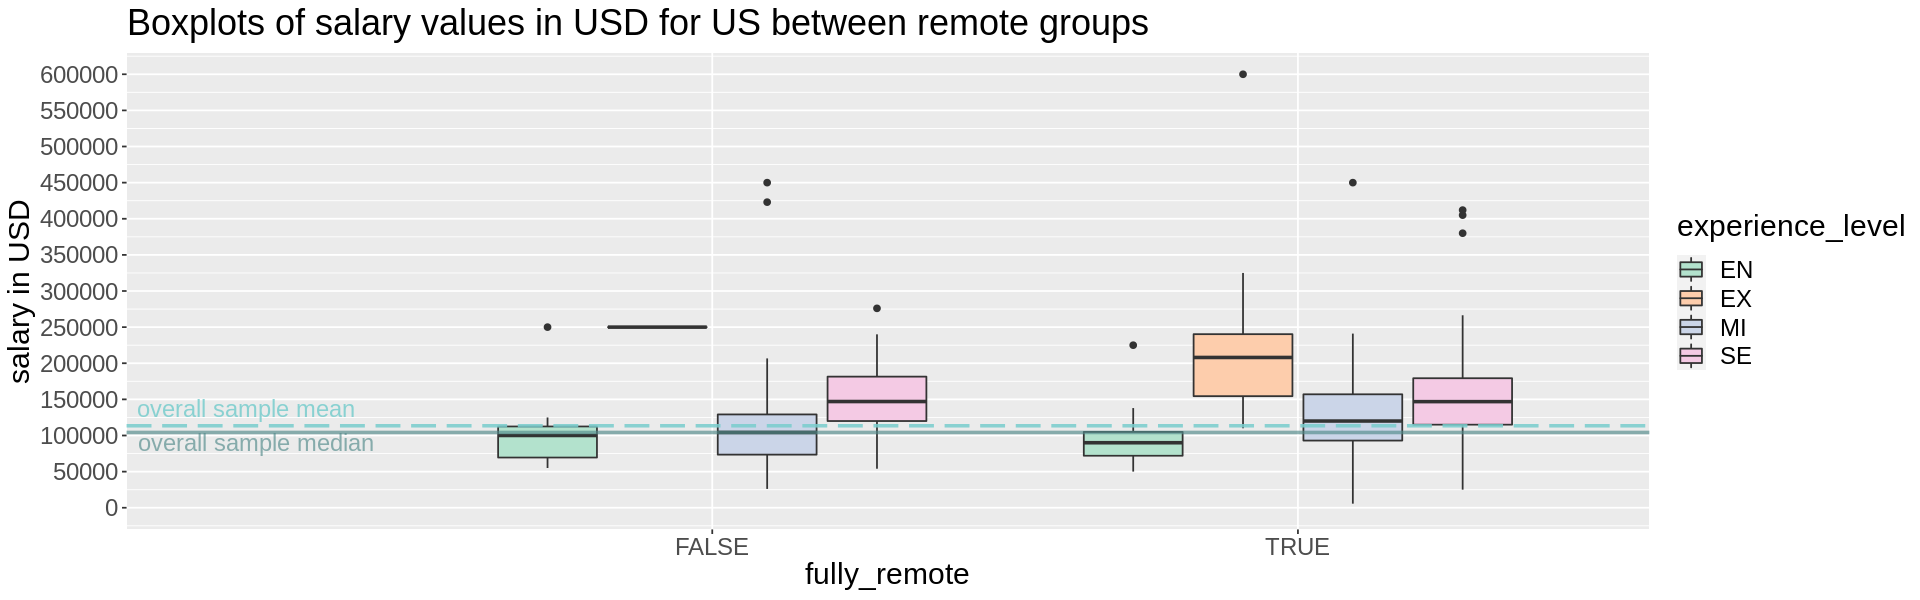

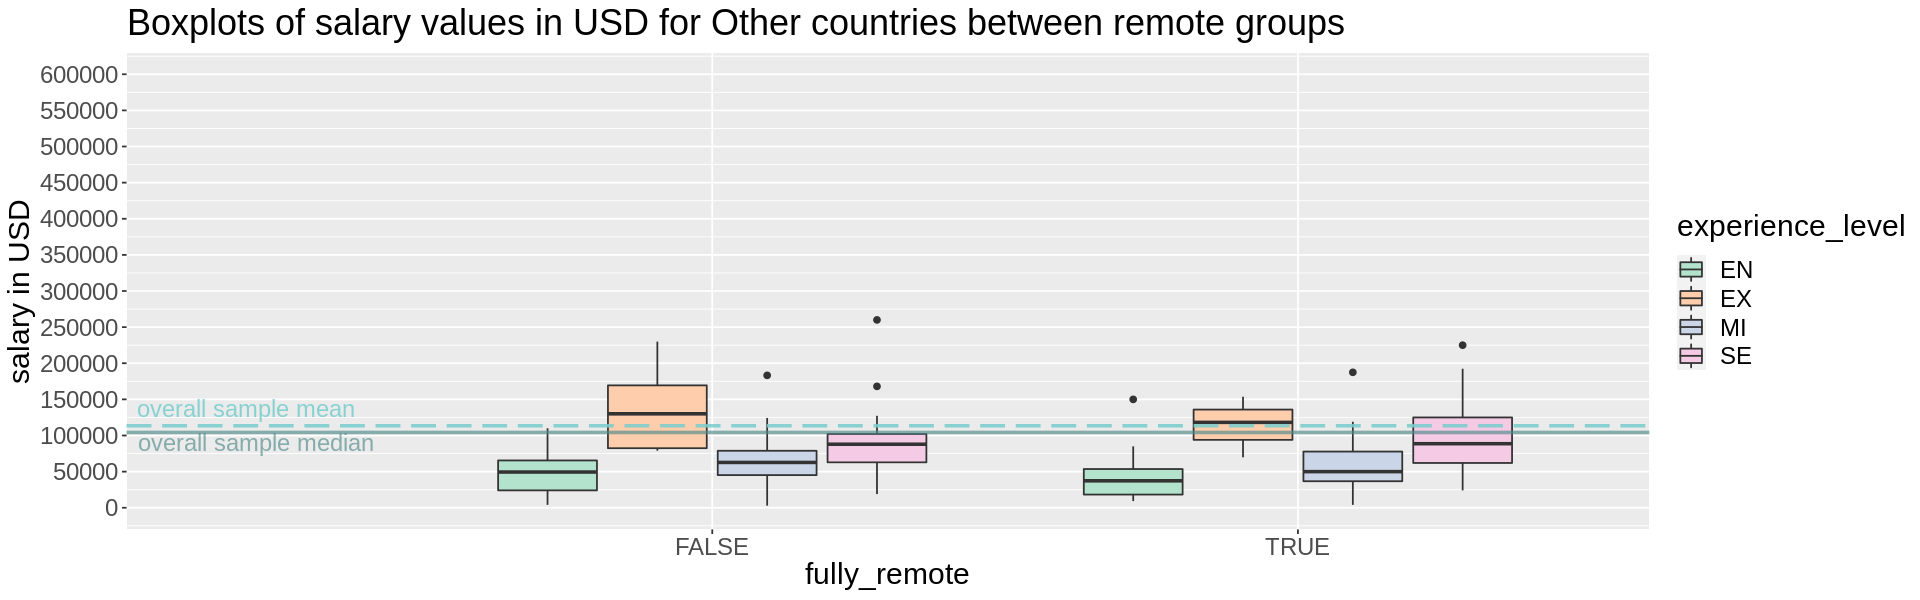

In [59]:
options(repr.plot.width = 16, repr.plot.height = 5)
options("scipen"=10, "digits"=4)

#Within US between remote groups among 4 exprience levels:
boxplots_US <- us_remote_binary %>%  
    ggplot(aes(x = fully_remote, y = salary_in_usd, fill = experience_level)) + 
    geom_boxplot() + 
    scale_fill_brewer(palette = "Pastel2") +
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD for US between remote groups") +
    theme(text = element_text(size=18)) +
    geom_hline(yintercept = mean_overall, color = "darkslategray3", size = 1, linetype = "longdash", alpha = 0.86) +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "darkslategray3", size=5, hjust = -0.05, vjust = -0.5, alpha = 0.86) +
    geom_hline(yintercept = median_overall, color = "darkslategray4", size = 1, linetype = "solid", alpha = 0.66) +
        annotate("text", x = 0, y = median_overall,label = "overall sample median", color = "darkslategray4", size=5, hjust = -0.05, vjust = 1.1, alpha = 0.66) +
    scale_y_continuous(limits = c(0, 600000), breaks = seq(0, 600000, 50000)) 
boxplots_US

# Within other countries between remote groups among 4 exprience levels:
others_remote_binary <-
    remote_binary %>% 
    filter(company_location !="US")

boxplots_Others <- others_remote_binary %>%  
    ggplot(aes(x = fully_remote, y = salary_in_usd, fill = experience_level)) + 
    geom_boxplot() + 
    scale_fill_brewer(palette = "Pastel2") +
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD for Other countries between remote groups") +
    theme(text = element_text(size=18)) +
    geom_hline(yintercept = mean_overall, color = "darkslategray3", size = 1, linetype = "longdash", alpha = 0.86) +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "darkslategray3", size=5, hjust = -0.05, vjust = -0.5, alpha = 0.86) +
    geom_hline(yintercept = median_overall, color = "darkslategray4", size = 1, linetype = "solid", alpha = 0.66) +
        annotate("text", x = 0, y = median_overall,label = "overall sample median", color = "darkslategray4", size=5, hjust = -0.05, vjust = 1.1, alpha = 0.66) +
    scale_y_continuous(limits = c(0, 600000), breaks = seq(0, 600000, 50000)) 
    
boxplots_Others


## 4. References

“Ai-Jobs.net Salaries.” Salaries.ai, https://salaries.ai-jobs.net/. 

Bhatia, Ruchi. “Data Science Job Salaries.” Kaggle, 15 June 2022, https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries. 

Brynjolfsson, Erik, et al. “Covid-19 and Remote Work: An Early Look at US Data.” 2020, https://doi.org/10.3386/w27344.

Galanti, Teresa et al. “Work From Home During the COVID-19 Outbreak: The Impact on Employees' Remote Work Productivity, Engagement, and Stress.” Journal of occupational and environmental medicine vol. 63,7 (2021): e426-e432. doi:10.1097/JOM.0000000000002236